In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import sys
from scipy import sparse
from tqdm import tqdm
from sklearn.cluster import KMeans

def toarr0(mtx,w,zsn):
    '''
    input: mtx, sparse matrix, [gene num, cell number]
    
    change the data of genes with indices w in the sparse matrix 
    to array; also make the zero point into -mu/sigma, for z-score
    normalization
    
    for z-score check
    
    output: np.array, [gene num,cell_num],

    '''
    
    nw = np.size(w)
    na = np.zeros([nw,mtx.shape[1]])
    test = mtx[w,:]
    for i in range(nw):
        na[i,:] = zsn[w[i]]
    na[test.nonzero()] = test.data
    
    return(na)

def toarr(mtx,w,zsn):
    '''
    input: mtx, sparse matrix, [gene num, cell number]
    
    change the data of cells with indices w in the sparse matrix 
    to array; also make the zero point into -mu/sigma, for z-score
    normalization
    
    output: np.array, [cell_use number, gene num], already transposed for simple_planes.py
    '''
    nw = np.size(w)
    na = np.zeros([mtx.shape[0],nw])
    test = mtx[:,w]
    for i in range(mtx.shape[0]):
        na[i,:] = zsn[i]
    na[test.nonzero()] = test.data
    
    return(na.T)


def plane_cutting(X,trials, cell_sample,cluster_param):
    feature_weights = np.hstack([PCMBK(X,cell_sample,cluster_param) for k in tqdm(range(trials))])
    return feature_weights


def PCMBK(X,cell_sample,k_sub):
    n_cells,n_genes = X.shape
    cell_use = np.random.choice(np.arange(n_cells),cell_sample,replace = False)
    k_sub_i = np.random.randint(k_sub[0],k_sub[1])
    k_guess = KMeans(k_sub_i).fit_predict(X[cell_use,:])
    #k_guess = KMeans(k_sub_i).fit_predict(toarr(X,cell_use,zsn))
    gnout = np.array([one_tree(X,cell_use,k_guess,ikk1,ikk2) for ikk1 in np.unique(k_guess) for ikk2 in np.unique(k_guess) if ikk1<ikk2 ])
    return np.hstack(gnout)


def one_tree(X,cu,k_guess,ik1,ik2,md = 1):
    Xit = X[cu,:]  
    #Xit = toarr(X,cu,zsn)        
    clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = md)
    XTT = Xit[np.logical_or(k_guess==ik1,k_guess==ik2),:]
    KTT = k_guess[np.logical_or(k_guess==ik1,k_guess==ik2)]
    clf.fit(XTT,KTT)
    feature_pick = np.flatnonzero(clf.feature_importances_)
    return feature_pick

In [3]:
Xs = np.load(f'/n/home06/minhuan/test/Multi_Model_Mapping/normalized_X/X_shuffle.npy',allow_pickle=True).all()
zsn = np.load(f'/n/home06/minhuan/test/Multi_Model_Mapping/normalized_X/z0value_noshuffle.npy')

In [4]:
M = 100
XXs = toarr0(Xs,range(M),zsn)
XXs=XXs.T

In [8]:
for ki in range(20):
    iterations = 100
    n_sub = 1000
    CP = [20,75]
    FW=plane_cutting(XXs,iterations,n_sub,CP)
    np.save(f'/n/home06/minhuan/test/Multi_Model_Mapping/normalized_X/Out/gs2_{ki}.npy',FW)

100%|██████████| 100/100 [02:48<00:00,  1.69s/it]


In [5]:
import numpy as np

base_dir = f'/n/home06/minhuan/test/Multi_Model_Mapping/normalized_X/Out/'
FW = np.hstack([np.load(base_dir+f'gd1_{k}.npy') for k in range(20)])
gx,_ = np.histogram(FW, np.arange(FW.max()+1), density = True)

FW = np.hstack([np.load(base_dir+f'gs2_{k}.npy') for k in range(20)])
gs,_ = np.histogram(FW, np.arange(FW.max()+1), density = True)

FW = np.hstack([np.load(base_dir+f'gs_sye_{k}.npy') for k in range(5)])
gs0,_ = np.histogram(FW, np.arange(FW.max()+1), density = True)

In [6]:
zd1 = (gx-gs.mean())/gs.std()

In [7]:
zd0 = (gx-gs0.mean())/gs0.std()

In [8]:
import matplotlib.pyplot as plt

In [21]:
w = np.where(zd1 > 1)
ww = np.where(zd1 < 1)

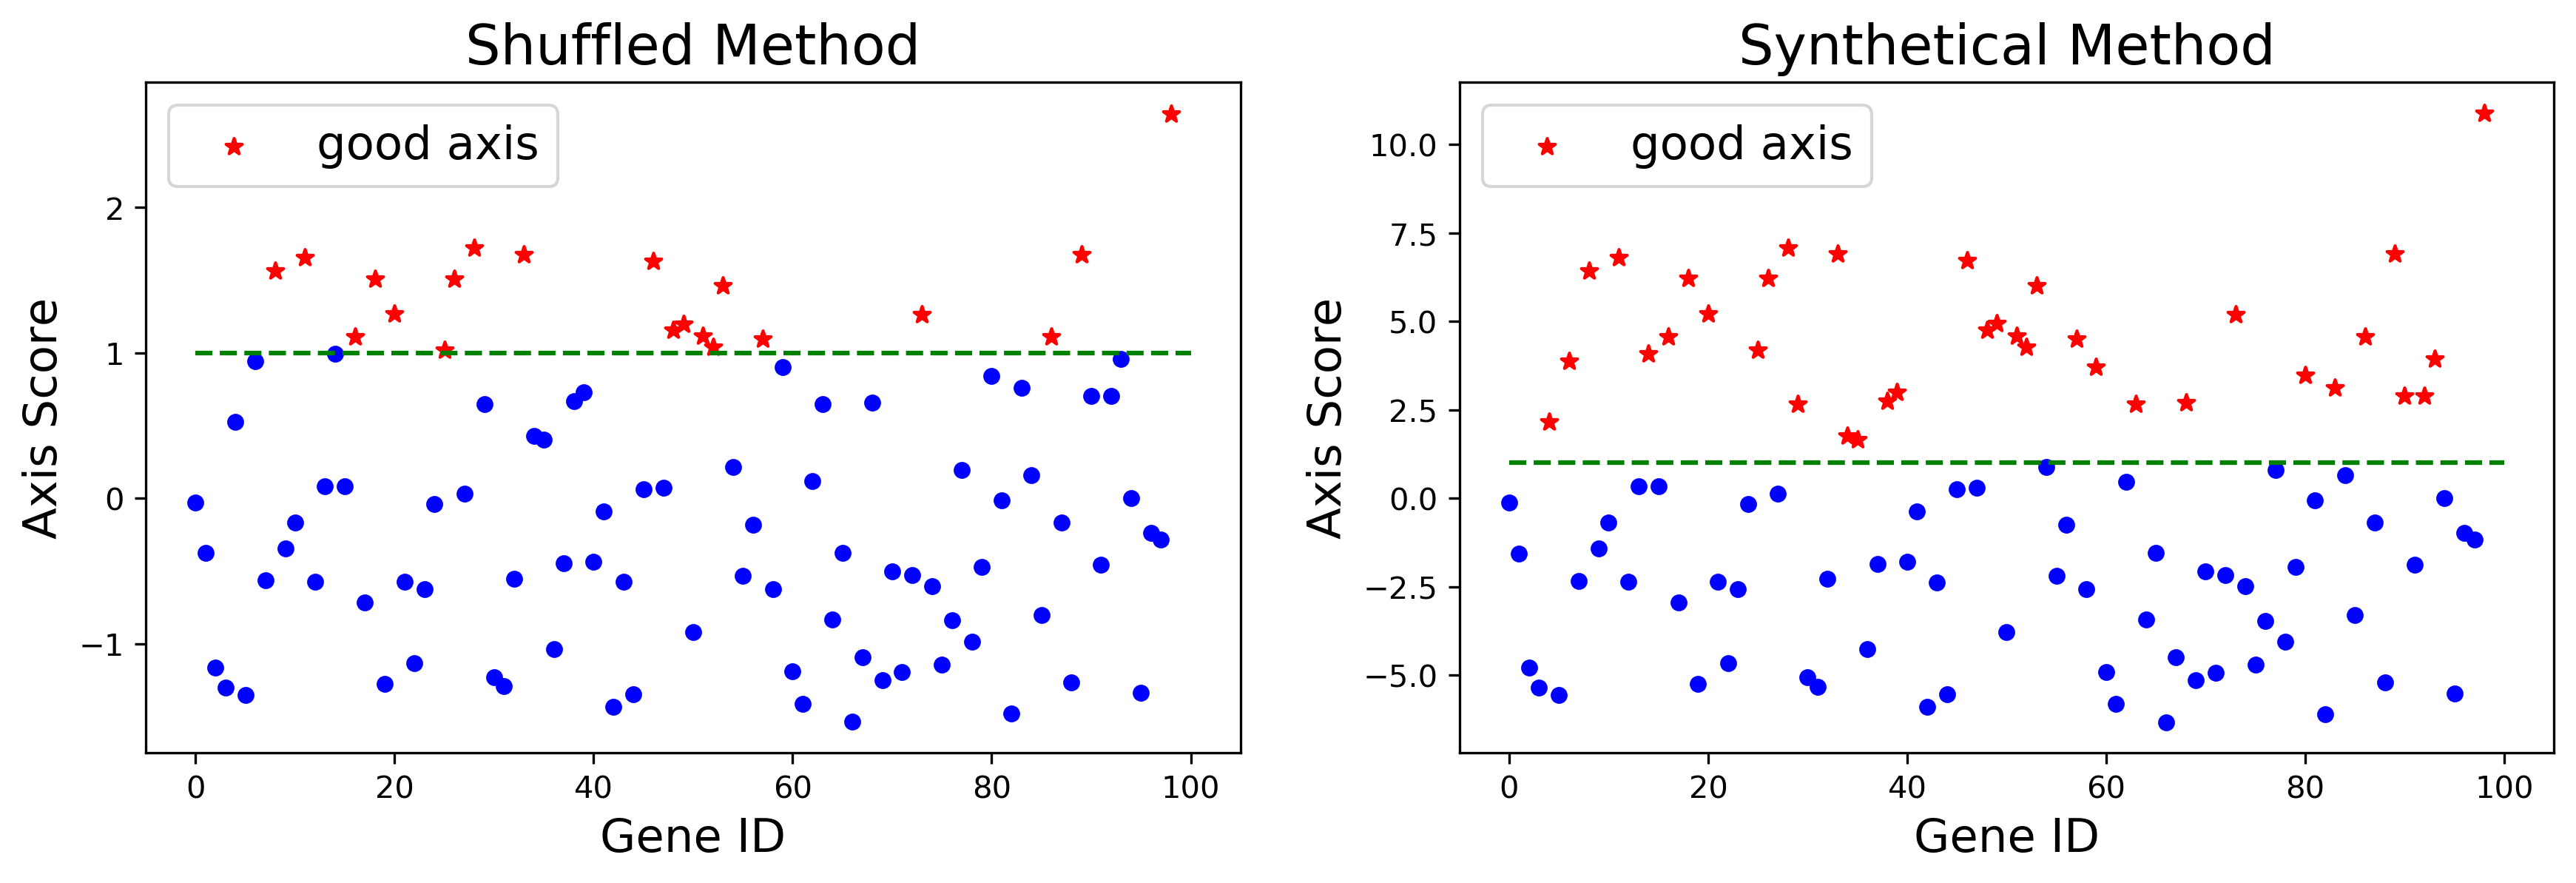

In [20]:
fig = plt.figure(dpi=300,figsize=(14,4))
#fig.suptitle('Fig 1. Mean and Deviation befroe Normalization', fontsize=12,x=0.53,y=0.15)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


w = np.where(zd1 > 1)
ww = np.where(zd1 < 1)

ax1.scatter(ww,zd1[ww],s=20,c='b')
ax1.scatter(w,zd1[w],s=30,c='r',marker = '*',label = 'good axis')
ax1.legend(fontsize=15)
ax1.set_xlabel('Gene ID', fontsize = 15)
ax1.set_ylabel('Axis Score',fontsize=15)
ax1.hlines(1,0,100,colors='g',linestyles='dashed')
ax1.set_title('Shuffled Method',fontsize = 18)

w = np.where(zd0 > 1)
ww = np.where(zd0 < 1)

ax2.scatter(ww,zd0[ww],s=20,c='b')
ax2.scatter(w,zd0[w],s=30,c='r',marker = '*',label = 'good axis')
ax2.legend(fontsize=15)
ax2.set_xlabel('Gene ID', fontsize = 15)
ax2.set_ylabel('Axis Score',fontsize=15)
ax2.hlines(1,0,100,colors='g',linestyles='dashed')
ax2.set_title('Synthetical Method',fontsize = 18)


plt.show()

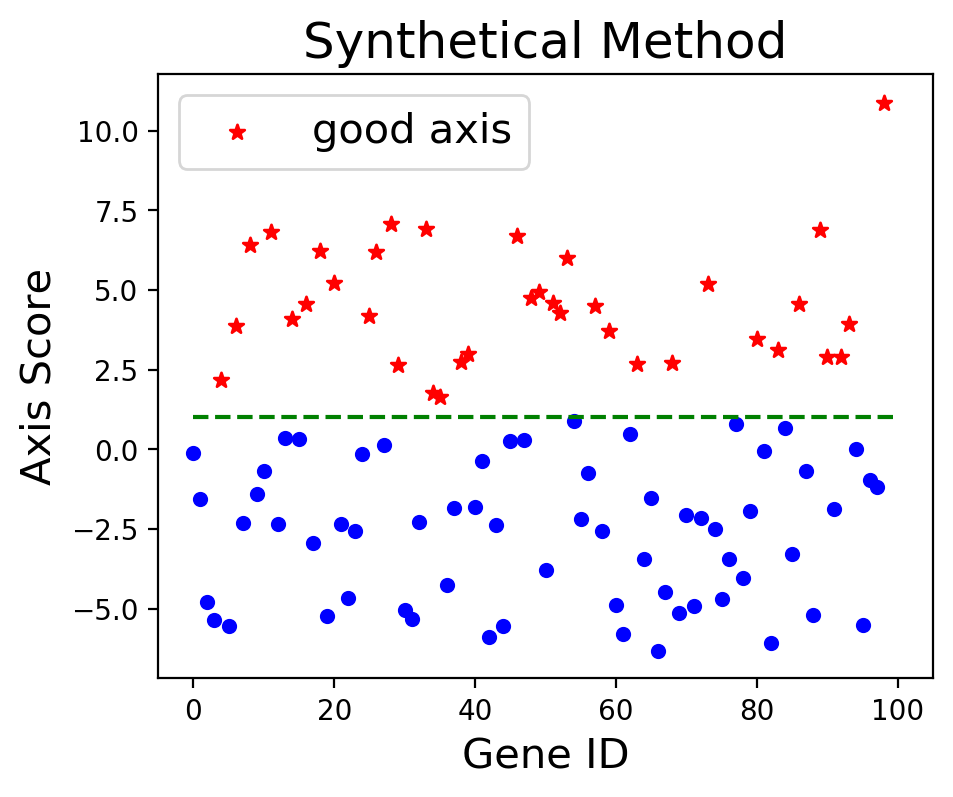

In [15]:
w = np.where(zd0 > 1)
ww = np.where(zd0 < 1)
plt.figure(dpi=200,figsize=[5,4])
plt.scatter(ww,zd0[ww],s=20,c='b')
plt.scatter(w,zd0[w],s=30,c='r',marker = '*',label = 'good axis')
plt.legend(fontsize=15)
plt.xlabel('Gene ID', fontsize = 15)
plt.ylabel('Axis Score',fontsize=15)
plt.hlines(1,0,100,colors='g',linestyles='dashed')
plt.title('Synthetical Method',fontsize = 18)
plt.show()

In [11]:
np.size(w)

36

In [46]:
geneinfo = np.load(f'/n/home06/minhuan/test/Multi_Model_Mapping/normalized_X/geneinfo.npy')

In [48]:
geneinfo = geneinfo[0:100]

In [49]:
geneinfo

array([['ENSMUSG00000025902', 'Sox17'],
       ['ENSMUSG00000033845', 'Mrpl15'],
       ['ENSMUSG00000025903', 'Lypla1'],
       ['ENSMUSG00000033813', 'Tcea1'],
       ['ENSMUSG00000002459', 'Rgs20'],
       ['ENSMUSG00000033793', 'Atp6v1h'],
       ['ENSMUSG00000025905', 'Oprk1'],
       ['ENSMUSG00000025907', 'Rb1cc1'],
       ['ENSMUSG00000090031', '4732440D04Rik'],
       ['ENSMUSG00000087247', 'Fam150a'],
       ['ENSMUSG00000051285', 'Pcmtd1'],
       ['ENSMUSG00000097797', 'Gm26901'],
       ['ENSMUSG00000061024', 'Rrs1'],
       ['ENSMUSG00000025911', 'Adhfe1'],
       ['ENSMUSG00000025912', 'Mybl1'],
       ['ENSMUSG00000045210', 'Vcpip1'],
       ['ENSMUSG00000097893', '1700034P13Rik'],
       ['ENSMUSG00000025915', 'Sgk3'],
       ['ENSMUSG00000046101', 'Mcmdc2'],
       ['ENSMUSG00000098234', 'Snhg6'],
       ['ENSMUSG00000099032', 'Tcf24'],
       ['ENSMUSG00000025917', 'Cops5'],
       ['ENSMUSG00000056763', 'Cspp1'],
       ['ENSMUSG00000067851', 'Arfgef1'],
       ['EN

In [58]:
w1 = np.argsort(zd1)
w1

array([66, 82, 42, 61,  5, 44, 95,  3, 31, 19, 88, 69, 30, 71, 60,  2, 75,
       22, 67, 36, 78, 50, 76, 64, 85, 17, 23, 58, 74, 43, 21, 12,  7, 32,
       55, 72, 70, 79, 91, 37, 40,  1, 65,  9, 97, 96, 56, 10, 87, 41, 24,
        0, 81, 94, 27, 45, 47, 15, 13, 62, 84, 77, 54, 35, 34,  4, 29, 63,
       68, 38, 92, 90, 39, 83, 80, 59,  6, 93, 14, 25, 52, 57, 16, 86, 51,
       48, 49, 73, 20, 53, 26, 18,  8, 46, 11, 89, 33, 28, 98])

In [59]:
w1l5 = w1[-5:]

In [60]:
w1l5

array([11, 89, 33, 28, 98])

In [61]:
print(geneinfo[w1l5])

[['ENSMUSG00000097797' 'Gm26901']
 ['ENSMUSG00000037408' 'Cnnm4']
 ['ENSMUSG00000025932' 'Eya1']
 ['ENSMUSG00000025938' 'Slco5a1']
 ['ENSMUSG00000026113' 'Inpp4a']]


In [62]:
print(zd1[w1l5])

[1.65572146 1.6772652  1.67747538 1.71919667 2.64242466]


In [67]:
w0 = np.argsort(zd0)
w0

array([66, 82, 42, 61,  5, 44, 95,  3, 31, 19, 88, 69, 30, 71, 60,  2, 75,
       22, 67, 36, 78, 50, 76, 64, 85, 17, 23, 58, 74, 43, 21, 12,  7, 32,
       55, 72, 70, 79, 91, 37, 40,  1, 65,  9, 97, 96, 56, 10, 87, 41, 24,
        0, 81, 94, 27, 45, 47, 15, 13, 62, 84, 77, 54, 35, 34,  4, 29, 63,
       68, 38, 92, 90, 39, 83, 80, 59,  6, 93, 14, 25, 52, 57, 16, 86, 51,
       48, 49, 73, 20, 53, 26, 18,  8, 46, 11, 89, 33, 28, 98])

In [68]:
w0l5 = w0[-5:]

In [69]:
print(geneinfo[w0l5])

[['ENSMUSG00000097797' 'Gm26901']
 ['ENSMUSG00000037408' 'Cnnm4']
 ['ENSMUSG00000025932' 'Eya1']
 ['ENSMUSG00000025938' 'Slco5a1']
 ['ENSMUSG00000026113' 'Inpp4a']]


In [70]:
print(zd0[w0l5])

[ 6.81204674  6.900683    6.90154774  7.07319942 10.87158726]
